In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches
from scarches.models import tranVAE
from scarches.dataset import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
condition_key = 'condition'
cell_type_key = 'final_annotation'
target_conditions = []


tranvae_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [5]:
adata_all = sc.read(os.path.expanduser(f'~/Documents/benchmarking_datasets/Immune_ALL_human_wo_villani_rqr_normalized_hvg.h5ad'))
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)].copy()
target_adata = adata[adata.obs[condition_key].isin(target_conditions)].copy()
source_conditions = source_adata.obs[condition_key].unique().tolist()
source_labels = source_adata.obs[cell_type_key].unique().tolist()

In [6]:
tranvae = scarches.models.tranVAE(
    input_dim=source_adata.n_vars,
    conditions=source_conditions,
    cell_types=source_labels,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 9
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 9
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



In [7]:
tranvae.condition_encoder

{'Oetjen_A': 0,
 'Oetjen_P': 1,
 'Oetjen_U': 2,
 'Freytag': 3,
 '10X': 4,
 'Sun_sample1_CS': 5,
 'Sun_sample2_KC': 6,
 'Sun_sample3_TB': 7,
 'Sun_sample4_TC': 8}

In [8]:
tranvae.cell_type_encoder

{'CD16+ Monocytes': 0,
 'HSPCs': 1,
 'CD8+ T cells': 2,
 'Erythrocytes': 3,
 'CD10+ B cells': 4,
 'Plasmacytoid dendritic cells': 5,
 'Monocyte progenitors': 6,
 'CD20+ B cells': 7,
 'Monocyte-derived dendritic cells': 8,
 'Plasma cells': 9,
 'Erythroid progenitors': 10,
 'Megakaryocyte progenitors': 11,
 'NK cells': 12,
 'NKT cells': 13,
 'CD14+ Monocytes': 14,
 'CD4+ T cells': 15}

In [9]:
sup_trainer = scarches.trainers.tranVAETrainer(
    model=tranvae,
    adata=source_adata,
    condition_key=condition_key,
    cell_type_key=cell_type_key,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=1000,
    tau=0,
)

In [10]:
sup_trainer.train(
    n_epochs=tranvae_epochs,
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |██------------------| 14.0%  - epoch_loss: 3412.06 - epoch_recon_loss: 3392.32 - epoch_kl_loss:   41.31 - epoch_landmark_loss:    0.01 - epoch_landmark_accuracy_loss:    0.89 - val_loss: 3978.54 - val_recon_loss: 3960.13 - val_kl_loss:   41.40 - val_landmark_loss:    0.00 - val_landmark_accuracy_loss:    0.91
ADJUSTED LR
 |███-----------------| 17.2%  - epoch_loss: 3418.68 - epoch_recon_loss: 3396.83 - epoch_kl_loss:   41.29 - epoch_landmark_loss:    0.00 - epoch_landmark_accuracy_loss:    0.90 - val_loss: 4283.65 - val_recon_loss: 4262.25 - val_kl_loss:   41.39 - val_landmark_loss:    0.00 - val_landmark_accuracy_loss:    0.89
ADJUSTED LR
 |███-----------------| 18.6%  - epoch_loss: 3411.95 - epoch_recon_loss: 3388.72 - epoch_kl_loss:   41.30 - epoch_landmark_loss:    0.00 - epoch_landmark_accuracy_loss:    0.90 - val_loss: 4094.59 - val_recon_loss: 4071.82 - val_kl_loss:   41.39 - val_landmark_loss:    0.00 - val_landmark_accuracy_loss:    0.89
Stopping early: no improvement of mor

... storing 'celltype' as categorical
... storing 'batch' as categorical


[<AxesSubplot:title={'center':'batch'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>]

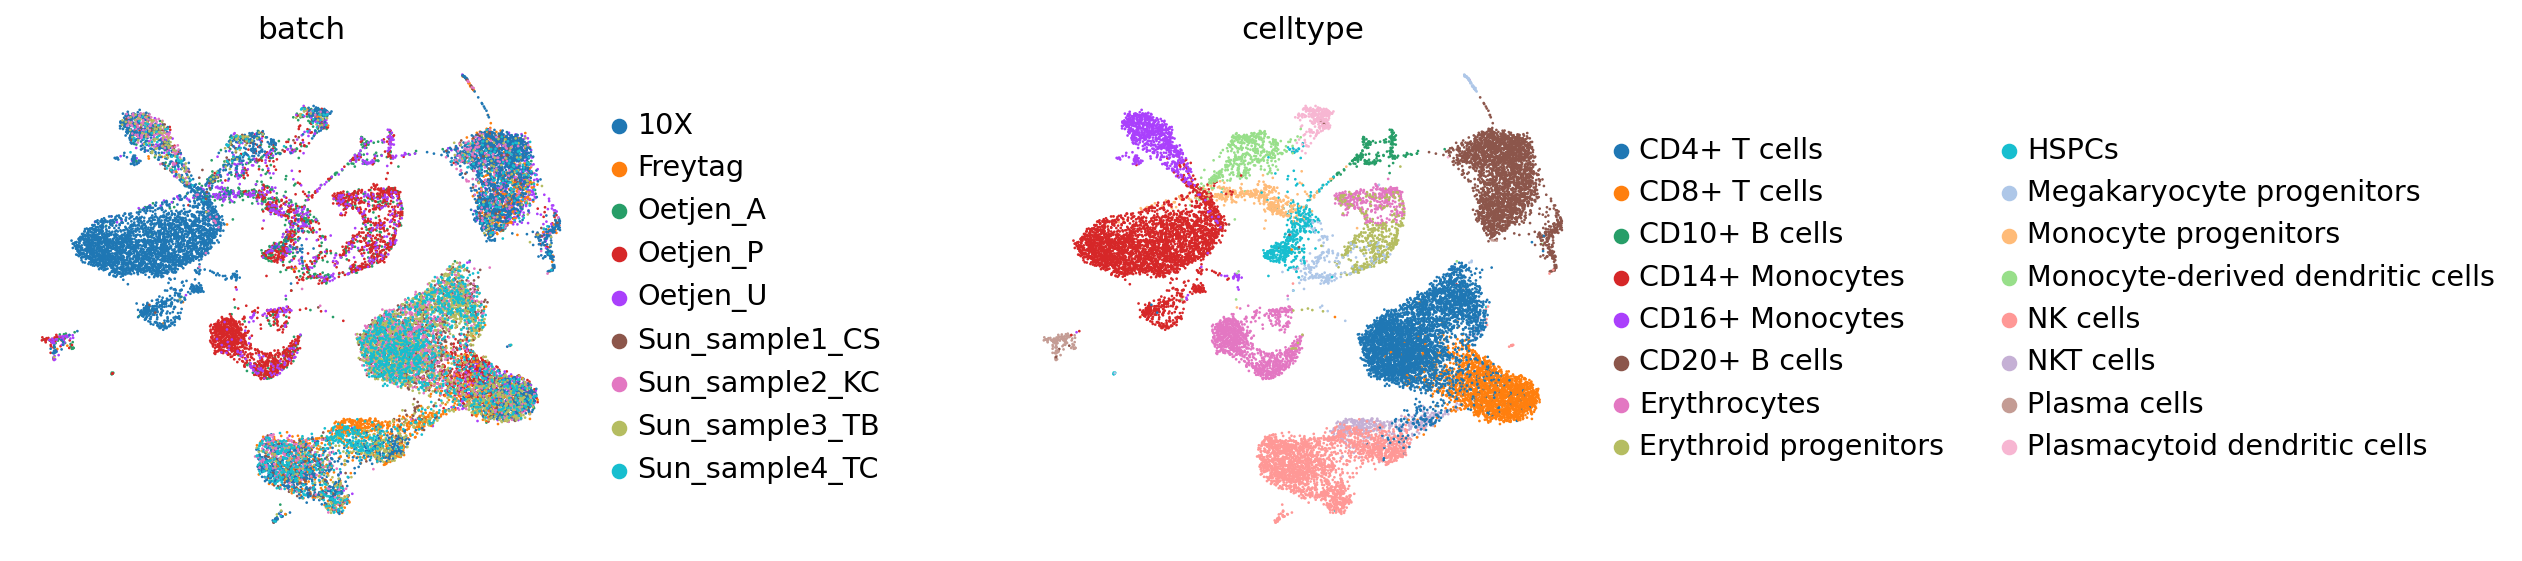

In [11]:
device = next(tranvae.parameters()).device
x = torch.tensor(source_adata.X, device=device)
c = np.asarray(source_adata.obs[condition_key])
labels = np.zeros(c.shape[0])
for condition, label in tranvae.condition_encoder.items():
    labels[c == condition] = label
c = torch.tensor(labels, device=device)

adata_latent = sc.AnnData(tranvae.get_latent(x, c).cpu().detach().numpy())
adata_latent.obs['celltype'] = source_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'celltype'],
           frameon=False,
           wspace=0.6,
           show=False
           )

In [12]:
landmarks = sup_trainer.landmarks.cpu().numpy()
landmarks

array([[-2.87e-01,  1.80e-01,  1.41e-01, -7.93e-02,  1.63e-01,  4.82e-01,
        -1.57e-01, -1.05e-01, -2.35e-01,  3.77e-01],
       [-2.45e-01,  3.29e-01,  1.60e-01,  4.75e-02,  1.94e-01,  4.94e-01,
        -1.85e-01, -1.27e-01, -1.96e-01,  4.67e-01],
       [-2.97e-01,  2.62e-01,  2.80e-01, -2.65e-02,  1.81e-01,  4.55e-01,
        -1.58e-01, -3.72e-02, -1.20e-01,  4.58e-01],
       [-1.13e-01,  1.94e-01,  2.27e-01,  1.28e-04,  1.47e-01,  4.93e-01,
        -1.57e-01, -8.18e-02, -7.42e-02,  4.53e-01],
       [-2.56e-01,  3.59e-01,  2.15e-01,  4.67e-02,  2.61e-01,  5.06e-01,
        -1.40e-01, -1.91e-01, -6.39e-02,  5.14e-01],
       [-1.27e-01,  3.14e-01,  1.52e-01,  7.16e-02,  3.21e-01,  4.89e-01,
        -2.11e-01, -1.77e-01, -1.80e-01,  4.58e-01],
       [-1.95e-01,  2.87e-01,  1.96e-01,  2.60e-02,  1.22e-01,  4.91e-01,
        -1.45e-01, -1.66e-01, -2.24e-01,  5.07e-01],
       [-2.45e-01,  2.26e-01,  2.80e-01,  2.75e-03,  2.84e-01,  4.96e-01,
        -1.58e-01, -1.51e-01, -9.04e-

In [13]:
extended_latent = adata_latent.X.copy()
extended_latent = np.concatenate((extended_latent, landmarks), axis=0)

extended_latent_labels = adata_latent.obs['celltype'].tolist()
landmark_names=[]
for i in range(landmarks.shape[0]):
    landmark_names.append(f'Landmark{i}')
extended_latent_labels+=landmark_names
    
extended_latent_batches = adata_latent.obs['batch'].tolist()
extended_latent_batches += landmarks.shape[0]*['Landmarks']

extended_latent = sc.AnnData(extended_latent)
extended_latent.obs['celltype'] = extended_latent_labels
extended_latent.obs['batch'] = extended_latent_batches
extended_latent

AnnData object with n_obs × n_vars = 20538 × 10
    obs: 'celltype', 'batch'

In [14]:
sc.pp.neighbors(extended_latent, n_neighbors=8)
sc.tl.leiden(extended_latent)
sc.tl.umap(extended_latent)

... storing 'celltype' as categorical
... storing 'batch' as categorical


<AxesSubplot:title={'center':'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>

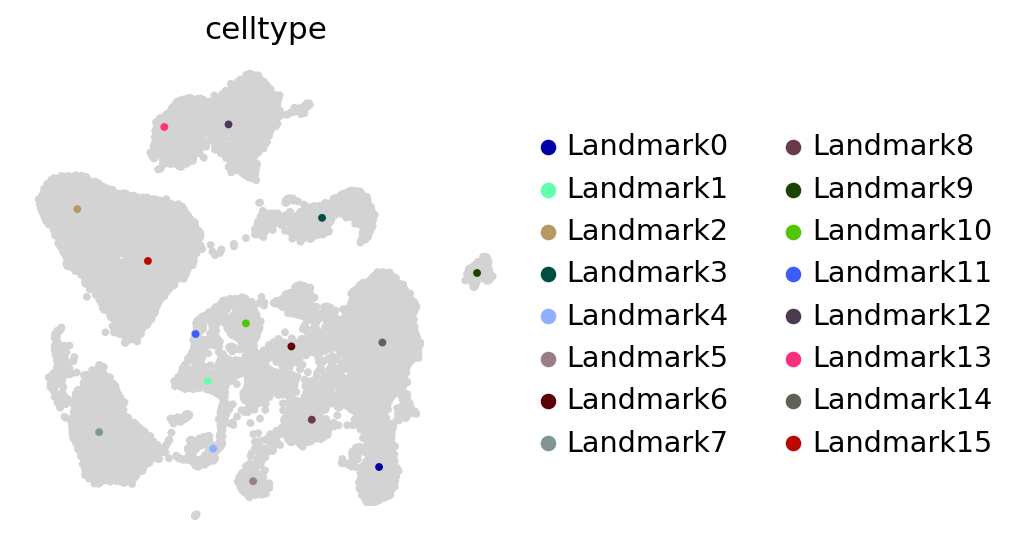

In [15]:
sc.pl.umap(extended_latent,
           color=['celltype'],
           groups=landmark_names,
           frameon=False,
           wspace=0.6,
           show=False,
           size=50
           )

<AxesSubplot:title={'center':'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>

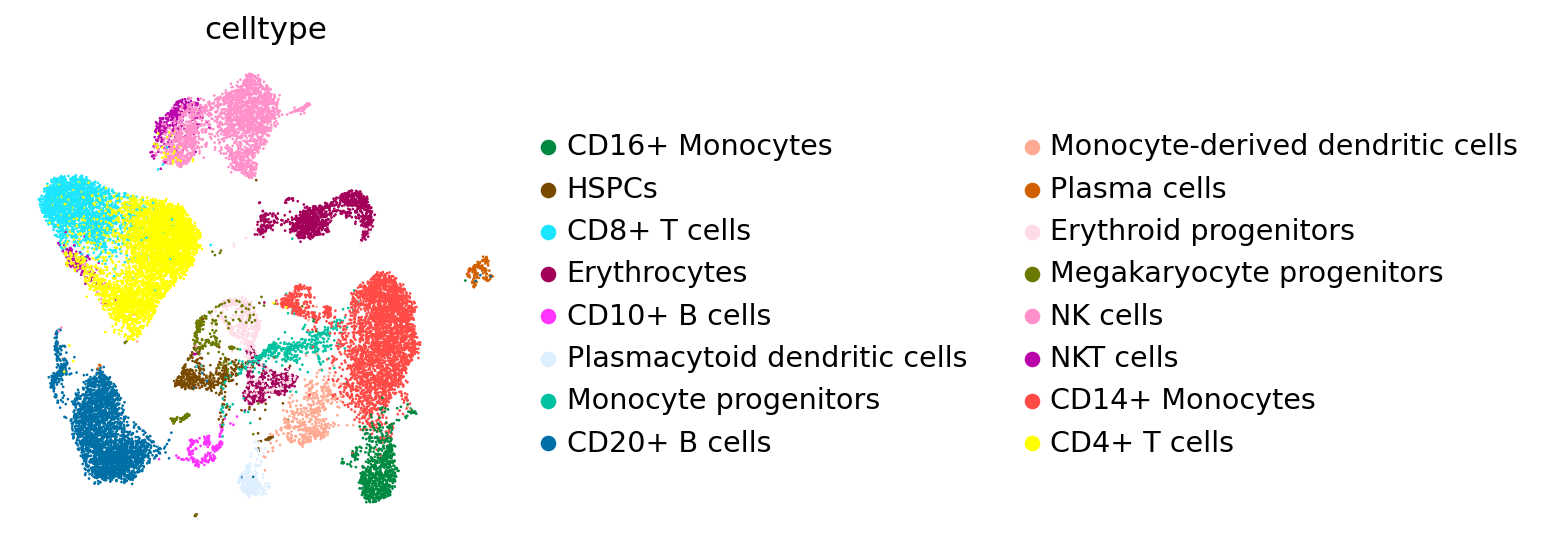

In [16]:
sc.pl.umap(extended_latent,
           color=['celltype'],
           frameon=False,
           groups=source_labels,
           wspace=0.6,
           show=False
           )